In [1]:
# The import statement lets you use functions in other modules
import os
# os has operating system interactions like manipulating paths

# You can change the name upon import for convenience in typing or to avoid overwriting other names
import numpy as np

% matplotlib inline
# A dot gives a submodule or object
import matplotlib.pyplot as plt

# You can also import a submodule, or a portion of a large project
from scipy import stats, linalg

# Array Basics

In [32]:
a = np.array([1, 2])
b = np.array([[1, 2], [1, 2]])
c = np.array([0, 0.5])

In [37]:
# The operations on these are not linear algebra, they are element-wise. No .^, .*, etc!
print(a ** 2.0)
print(b ** 2.0)
print(a * b)

print('\n\n')

# but I can do linear algebra if I want
print(a @ b)
print(b @ b)

print('\n\n')

# Convenient dot product
print(a @ a)

[ 1.  4.]
[[ 1.  4.]
 [ 1.  4.]]
[[1 4]
 [1 4]]



[3 6]
[[3 6]
 [3 6]]



5


## A few Gotchas
Python is smart about copying, but you need to be aware of that! This is a feature that lets you share/update data

In [4]:
d = a
print(d)
a[1] = 5
print(d)

# Go back to how we were
a[1] = 2

[1 2]
[1 5]


You can avoid this by copying or by indexed assignment

In [5]:
d = a.copy()
a[1] = 5
print(d)

# Go back to how we were
a[1] = 2

# OR use this less explcit way
d[:] = a
a[1] = 5
print(d)

# Go back to how we were
a[1] = 2

[1 2]
[1 2]


In [6]:
# Watch out for this!
d = a
d[1] = 5
print(a)

# Go back to how we were
a[1] = 2

[1 5]


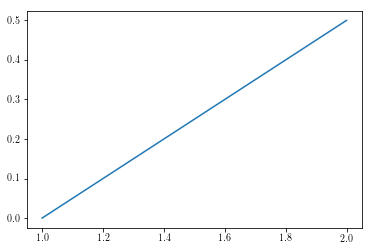

In [7]:
fig, ax = plt.subplots()
ax.plot(a, c)
plt.show(fig)

# Now let's use some scipy
## The problem
We have some noisy data provided in `data.txt` (if you want to make your own, you can use `make_datafile.py`). We want to make a nice plot with the data and a regressed fit. 
## Our approach
We will read the data in using pure python, then make numpy arrays out the data. We will then use a manual algorithm to compute a linear fit to get some practice with numpy, then we will fit the data using a canned routine. Then we will try to make a really pretty plot.

In [8]:
# Read in the noisy data
with open('data.txt', 'r') as fin:
    lines = fin.readlines()
    
lines = [line.rstrip('\n\r').split(' ') for line in lines]
lines = [list(map(float, line)) for line in lines]
data = np.array(lines)

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


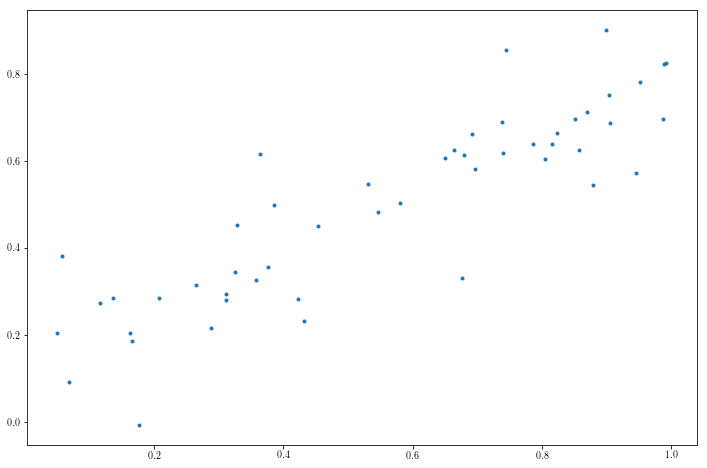

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data[:, 0], data[:, 1], linestyle='none', marker='.')
fig.show()

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


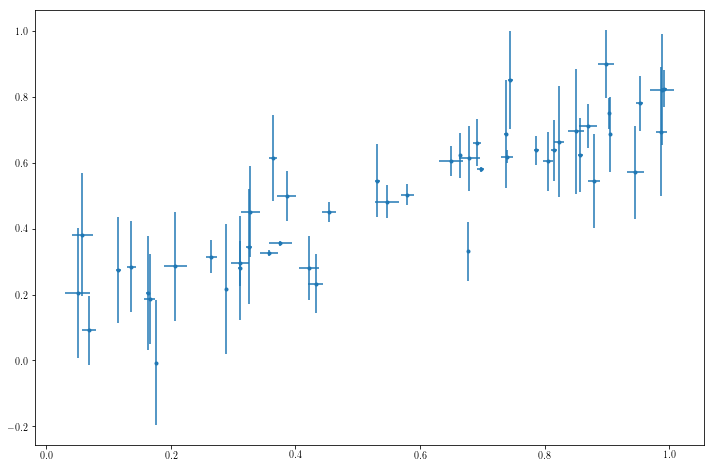

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
fig.show()

In [11]:
fit_info = stats.linregress(data[:, 0:2])
print(fit_info)

LinregressResult(slope=0.64336993189194347, intercept=0.13728228245177559, rvalue=0.87725143003180583, pvalue=6.5208197253472815e-17, stderr=0.050814247569019824)


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


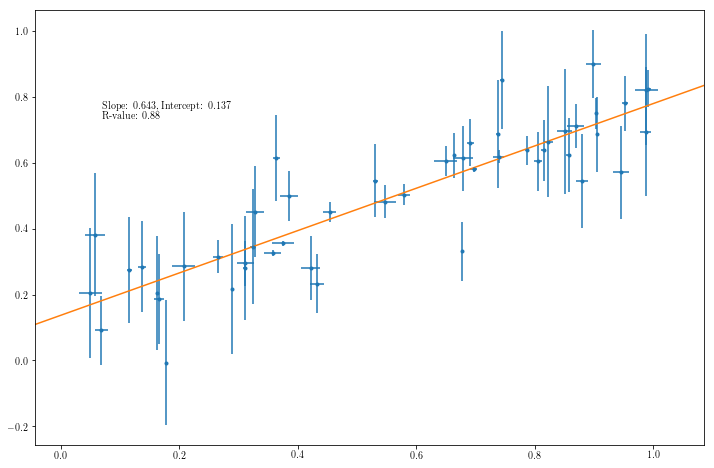

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
xmin, xmax = np.min(data[:, 0]), np.max(data[:, 0])
fit_x = np.linspace(xmin - (xmax - xmin) / 10., xmax + (xmax - xmin) / 10., 50)
ax.plot(fit_x, fit_x * fit_info.slope + fit_info.intercept)
ax.set_xlim(fit_x[0], fit_x[-1])
ax.text(0.1, 0.75, 'Slope: {:1.3f}, Intercept: {:1.3f}\nR-value: {:1.2f}'.format(fit_info.slope, fit_info.intercept, fit_info.rvalue), transform=ax.transAxes)
fig.show()

In [16]:
# Construct a matrix to solve by hand
a = np.ones(data[:, :2].shape)
a[:, 1] = data[:, 0]

# like good mathematicians, we will scale each row of the equations by our error (squared since we minimize the L2 norm)
y_err_sqr = data[:, 3] ** 2.0
scaled_a = a / np.repeat(np.atleast_2d(y_err_sqr), 2, axis=0).T
scaled_obs = data[:, 1] / y_err_sqr


[[ 1.  0.]
 [ 0.  1.]]
True
[[-31749.93290768 -14665.96855474]
 [     0.           4643.81975061]]


Let's solve this system in two different ways. We'll see how smart the numpy lstsq_sol algorithm is.

In [29]:
# Now let's solve using a QR factorization
q, r = np.linalg.qr(scaled_a)
# look, QR is nifty:
print(q.T @ q)
print(np.allclose(q @ r, scaled_a))
print(r)

%timeit q, r = np.linalg.qr(scaled_a); lstsq_sol = np.linalg.solve(r, np.dot(q.T, scaled_obs))
%timeit lstsq_sol, _, _, _ = np.linalg.lstsq(scaled_a, scaled_obs)

[[ 1.  0.]
 [ 0.  1.]]
True
[[-31749.93290768 -14665.96855474]
 [     0.           4643.81975061]]
82.4 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
69.2 µs ± 4.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Oooh, I almost beat it without using the fact that q is upper triangular; I could in fact beat it I were clever about that solve, but who cares. lstsq is easy.

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


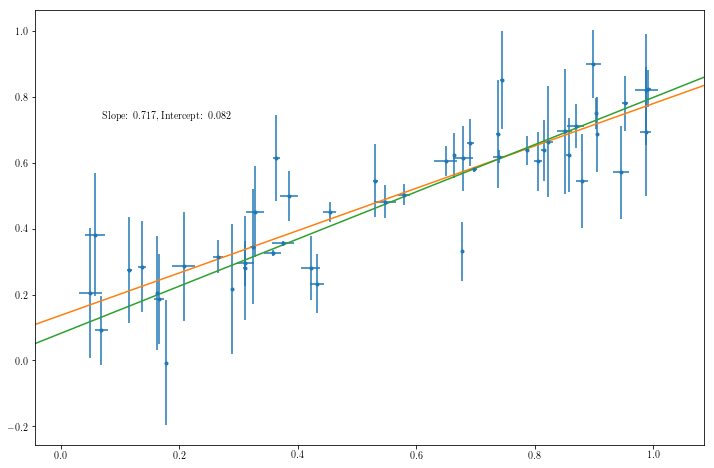

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
xmin, xmax = np.min(data[:, 0]), np.max(data[:, 0])
fit_x = np.linspace(xmin - (xmax - xmin) / 10., xmax + (xmax - xmin) / 10., 50)
ax.plot(fit_x, fit_x * fit_info.slope + fit_info.intercept)
ax.plot(fit_x, fit_x * lstsq_sol[1] + lstsq_sol[0])
ax.set_xlim(fit_x[0], fit_x[-1])
ax.text(0.1, 0.75, 'Slope: {:1.3f}, Intercept: {:1.3f}'.format(lstsq_sol[1], lstsq_sol[0]), transform=ax.transAxes)
fig.show()